# Credit Score Classification - MlFlow 

In [17]:
import mlflow
from mlflow.models import infer_signature
import pandas as pd
from sklearn import datasets
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_recall_curve,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
SEED= 42


In [3]:
#mlflow.set_tracking_uri(uri = "http://localhost:5000")

In [4]:
data_path = r"C:\Users\eda.emanet\Desktop\EDA\kisisel\Projeelr\Kredi Skorlama\Data\Credit Score Classification Dataset.csv"

In [5]:
#df= pd.read_csv("./Credit Score Classification Dataset.csv")
data = pd.read_csv(data_path, sep=",")
df = data.copy()
df.head()

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High


# Data Preprocess

In [6]:
df["Education"] = df["Education"].str.replace("Bachelor's Degree", "Bachelors_Degree")
df["Education"] = df["Education"].str.replace("Master's Degree", "Masters_Degree")
df["Education"] = df["Education"].str.replace("Associate's Degree", "Associates_Degree")


In [7]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

ordinal_map = {"Low": 0, "Average": 1, "High": 2}

df["Credit_Score_Encoded"] = df["Credit Score"].map(ordinal_map)

one_hot_cols = ["Gender", "Marital Status", "Home Ownership"] # home ownership i de ordinAL DENE
df_encoded = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

education_order = ['High School Diploma',"Associates_Degree" , 'Bachelors_Degree', 'Masters_Degree', 'Doctorate']
ordinal_encoder = OrdinalEncoder(categories=[education_order])
df_encoded["Education_encoded"] = ordinal_encoder.fit_transform(df[["Education"]])

df_encoded.drop("Education", axis=1, inplace=True)




In [29]:
x= df_encoded[['Age','Income', 'Number of Children','Gender_Male', 'Marital Status_Single', 'Home Ownership_Rented', 'Education_encoded' ]]
y= df_encoded[['Credit_Score_Encoded']]
x.columns = x.columns.str.replace(" ", "_")

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED, stratify=y, 
    shuffle=True )

## Experiment 1: Random Forest

In [18]:
# Random Forest 
rf = RandomForestClassifier()
st = StandardScaler()
st.fit(x_train)
model = rf.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy_score(y_test, pred)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      0.86      0.86         7
           2       0.96      0.96      0.96        23

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33



## Experiment 2: Random Forest with SMOTE

In [19]:
# Dengesiz sınıf problemini çözmek için 
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

rf = RandomForestClassifier()
st = StandardScaler()
st.fit(x_train)
model_sm = rf.fit(x_train_smote, y_train_smote)
pred = model_sm.predict(x_test)
accuracy_score(y_test, pred)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      0.86      0.86         7
           2       0.96      0.96      0.96        23

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33



## Experiment 3: XGBoost

In [20]:
xgb = XGBClassifier()
st.fit(x_train)
model_xgb = xgb.fit(x_train, y_train)
pred_xg = model_xgb.predict(x_test)
print(classification_report(y_test, pred_xg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.86      0.92         7
           2       0.96      1.00      0.98        23

    accuracy                           0.97        33
   macro avg       0.99      0.95      0.97        33
weighted avg       0.97      0.97      0.97        33



## Experiment 4: XGB with SMOTE 

In [21]:
xgb = XGBClassifier()
st.fit(x_train_smote)
model_xgb = xgb.fit(x_train_smote, y_train_smote)
pred_xg = model_xgb.predict(x_test)
print(classification_report(y_test, pred_xg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        23

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [22]:
mlflow.set_tracking_uri(uri = "http://localhost:5000")

# Track Experiments Using MLFlow


In [33]:
models = [
    (
        "Logistic Regression", 
        LogisticRegression(C=1, solver='liblinear'), 
        (x_train, y_train),
        (x_test, y_test)
    ),
    (
        "Random Forest", 
        RandomForestClassifier(n_estimators=30, max_depth=3), 
        (x_train, y_train),
        (x_test, y_test)
    ),
    (
        "XGBClassifier",
        XGBClassifier( eval_metric='logloss'), 
        (x_train, y_train),
        (x_test, y_test)
    ),
    (
        "XGBClassifier With SMOTE",
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
        (x_train_smote, y_train_smote),
        (x_test, y_test)
    )
]

In [35]:
reports = []

for model_name, model, train_set, test_set in models:
    x_train = train_set[0]
    y_train = train_set[1]
    x_test = test_set[0]
    y_test = test_set[1]
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

In [39]:
# Initialize MLflow
mlflow.set_experiment("Credit Score Prediction")
mlflow.set_tracking_uri("http://localhost:5000")

for i, element in enumerate(models):
    model_name = element[0]
    model = element[1]
    report = reports[i]
    
    with mlflow.start_run(run_name=model_name):        
        mlflow.log_param("model", model_name)
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('recall_class_1', report['1']['recall'])
        mlflow.log_metric('recall_class_0', report['0']['recall'])
        mlflow.log_metric('f1_score_macro', report['macro avg']['f1-score'])        
        
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")  

2025/04/23 14:50:27 INFO mlflow.tracking.fluent: Experiment with name 'Credit Score Prediction' does not exist. Creating a new experiment.
2025/04/23 14:50:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/1/runs/f2693bd4dadf4309b379988afa81ca9a
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/04/23 14:50:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/1/runs/6516b7340a14407da95556ddd51b5649
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/04/23 14:50:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier at: http://localhost:5000/#/experiments/1/runs/264d47a33b9b4b208a48fec20070605a
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/04/23 14:50:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier With SMOTE at: http://localhost:5000/#/experiments/1/runs/14c306f118634ca299417ba99210514c
🧪 View experiment at: http://localhost:5000/#/experiments/1


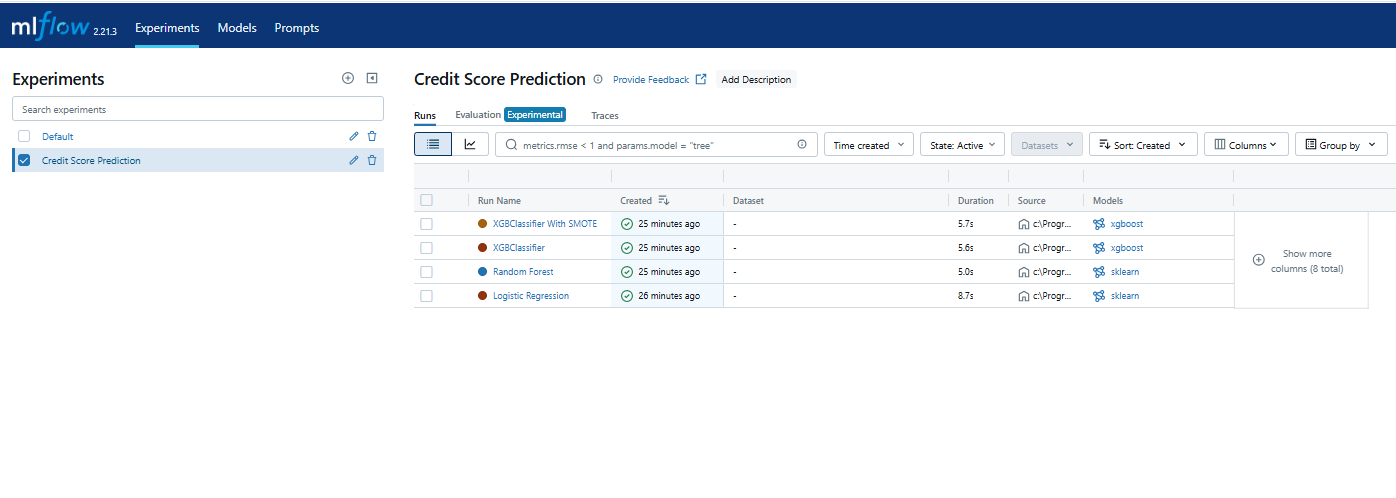

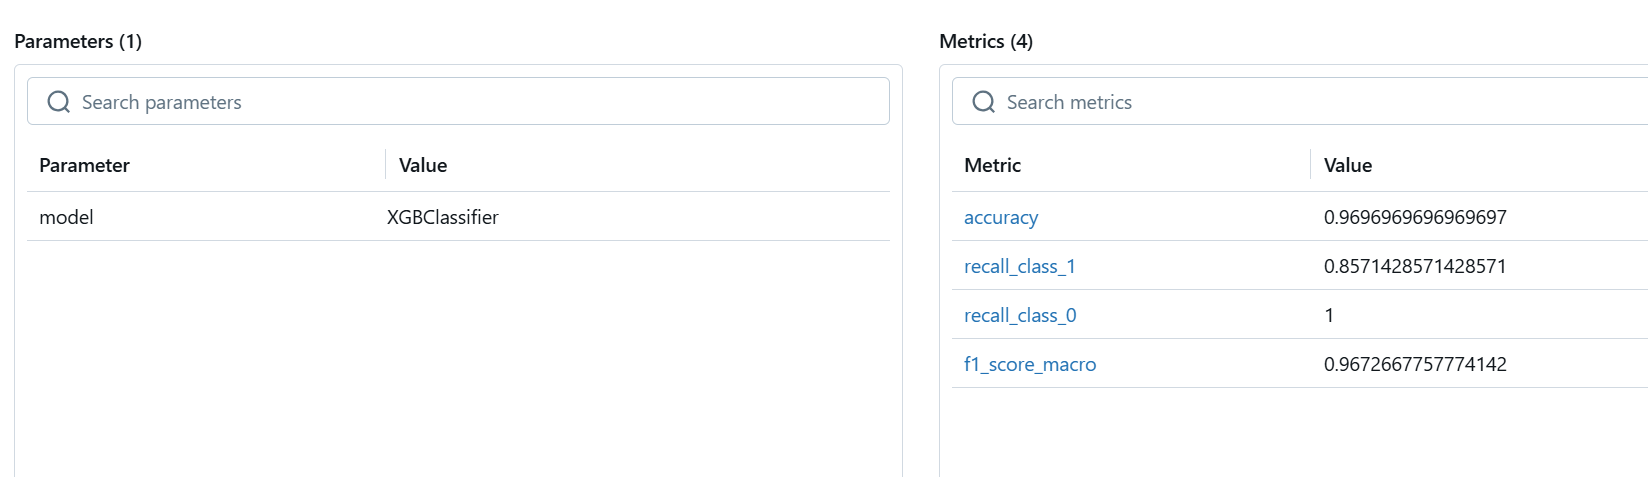